In this notebook we will approach for the first time PyTorch. 
First we see how `torch` can help us to avoid long `numpy` code and then we will see how to use `torch` to build a simple neural network for classification.

The total number of point available in this notebook is 7, but the maximum score you can get is 6, so one extra point is available.
# Part 1: From Numpy to PyTorch [2.5 points]

**What will you learn in this part**:
- Tensors syntax
- Autograd
- Neural Network modules

Let's get back to last week exercise and migrate it to PyTorch. Luckily, the syntax is almost identical. The main difference is that *arrays* are replaced by *tensors*, and all the `np.*` functions become `torch.*`. For more advanced functionalities, we refer you to the [official documentation][torch_doc].

[torch_doc]: https://pytorch.org/docs/stable/index.html

## Single layer MLP in Numpy

Recall the feedforward neural network with a single hidden layer.

![simple_mlp](./simple_mlp.png)

Below is the Numpy implementation of the activations and the feedforward propagation

In [1]:
import numpy as np
from typing import Tuple
from numpy.typing import NDArray

def np_sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1 + np.exp(-t))

def np_grad_sigmoid(t):
    """return the derivative of sigmoid on t."""
    return np_sigmoid(t) * (1 - np_sigmoid(t))

def np_mlp(
    x: NDArray[np.float_], w_1: NDArray[np.float_], w_2: NDArray[np.float_]
) -> Tuple[NDArray[np.float_], NDArray[np.float_], NDArray[np.float_]]:
    """Feed forward propagation on MLP

    Args:
        x (NDArray[np.float_]): Input vector of shape (d_in,)
        w_1 (NDArray[np.float_]): Parameter matrix of first hidden layer, of shape (d_in, d_hid)
        w_2 (NDArray[np.float_]): Parameter vector of output layer, of shape (d_hid,)

    Returns:
        Tuple[NDArray[np.float], NDArray[np.float], NDArray[np.float]]: Three
            arrays `y_hat`, `z_1`, `z_2`, containing repsectively the output and
            the two preactivations.
    """
    z_1 = w_1.T @ x
    x_1 = np_sigmoid(z_1)
    z_2 = w_2.T @ x_1
    y_hat = np_sigmoid(z_2)
    
    return y_hat, z_1, z_2


And this is the backpropagation with the Mean-squared error loss $\mathcal L (y, \hat y) = \frac{1}{2} \left( y - \hat y \right)^2$:

In [2]:
def np_mlp_backpropagation(
    y: NDArray[np.int_],
    x: NDArray[np.float_],
    w_2: NDArray[np.float_],
    y_hat: NDArray[np.float_],
    z_1: NDArray[np.float_],
    z_2: NDArray[np.float_],
) -> Tuple[NDArray[np.float_], NDArray[np.float_]]:
    """Do backpropagation and get parameter gradients.

    Args:
        y (NDArray[np.int_]): True label
        x (NDArray[np.float_]): Input data
        w_2 (NDArray[np.float_]): Readout layer parameters
        y_hat (NDArray[np.float_]): MLP output
        z_1 (NDArray[np.float_]): Hidden layer preactivations
        z_2 (NDArray[np.float_]): Readout layer preactivations

    Returns:
        Tuple[NDArray[np.float_], NDArray[np.float_]]: Gradients of w_1 and w_2
    """
    # Feed forward
    _loss = 0.5 * (y - y_hat)**2

    # Backpropogation
    delta_2 = (y_hat - y) * np_grad_sigmoid(z_2)
    x_1 = np_sigmoid(z_1)
    dw_2 = delta_2 * x_1
    delta_1 = delta_2 * w_2* np_grad_sigmoid(z_1)
    dw_1 = np.outer(x, delta_1)

    return dw_1, dw_2

Now, we can compute the MLP output and retrieve the gradients

In [3]:
x_np = np.array([0.01, 0.02, 0.03, 0.04])
w_1_np = np.random.randn(4, 5)
w_2_np = np.random.randn(5)

y = 1

y_hat_np, z_1, z_2 = np_mlp(x_np, w_1_np, w_2_np)
dw_1_np, dw_2_np = np_mlp_backpropagation(y, x_np, w_2_np, y_hat_np, z_1, z_2)

print(dw_1_np.shape)
print(dw_2_np.shape)

(4, 5)
(5,)


This indeed works, but as soon as we change the neural network architecture we have to change our backpropagation function, and keep track of all the computations that involve each parameter. It is a lot of work which we want to delegate to the machine.
This is what *automatic differentiation* does, and libraries like PyTorch implement it.

## Exercise 1

We can manipulate tensors as we want and, by asking for `require_grad=True`, PyTorch handles automatic differentation!

In [4]:
import torch

In [5]:
# EXAMPLE

a = torch.randn(10, 5)
b = torch.ones(5, requires_grad=True)

# Note that c is a scalar
c = torch.log(abs(a @ b)).sum()
print("c", c)
print("c.shape:", c.shape)
print()

# We ask to perform backpropagation
c.backward()

print("b.grad:", b.grad)
print("b.grad.shape:", b.grad.shape)


c tensor(2.4401, grad_fn=<SumBackward0>)
c.shape: torch.Size([])

b.grad: tensor([ 8.4821, -4.4412,  8.8023,  0.5036, -3.3468])
b.grad.shape: torch.Size([5])


We now convert the previous code to PyTorch. Autograd is responsible of keeping track of each element in the computations, so we only need to implement the forward pass!

In [6]:
def sigmoid(t) -> torch.FloatTensor:
    """apply sigmoid function on t."""
    #vvvvv YOUR CODE HERE vvvvv#
    return 1.0 / (1 + torch.exp(-t))
    #^^^^^^^^^^^^^^^^^^^^^^^^^^#

def mlp(
    x: torch.Tensor, w_1: torch.Tensor, w_2: torch.Tensor
) -> torch.Tensor:
    """Feed forward propagation on MLP

    Args:
        x (torch.Tensor): Input vector of shape (d_in,)
        w_1 (torch.Tensor): Parameter matrix of first hidden layer, of shape (d_in, d_hid)
        w_2 (torch.Tensor): Parameter vector of output layer, of shape (d_hid,)

    Returns:
        torch.Tensor: Network output
    """
    #vvvvv YOUR CODE HERE vvvvv#
    z_1 = torch.matmul(w_1.T, x)    
    x_1 = torch.sigmoid(z_1)
    z_2 = torch.matmul(w_2.T, x_1)
    y_hat = torch.sigmoid(z_2)
    #^^^^^^^^^^^^^^^^^^^^^^^^^^#
    
    return y_hat


Now, we can verify that the output corresponds to the numpy implementation

In [7]:
#vvvvv YOUR CODE HERE vvvvv#

# Convert arrays to tensors. Mind that we will ask for parameters gradients!
w_1 = torch.tensor(w_1_np, requires_grad=True)
w_2 = torch.tensor(w_2_np, requires_grad=True)

#Now perform backpropagation
loss = 0.5 * (y - mlp(torch.tensor(x_np), w_1, w_2))**2  # Note that loss is a scalar   
loss.backward()

#^^^^^^^^^^^^^^^^^^^^^^^^^^#

print(np.allclose(w_1.grad.numpy(), dw_1_np))
print(np.allclose(w_2.grad.numpy(), dw_2_np))


True
True


C:\Users\goali\AppData\Local\Temp\ipykernel_2708\2690624971.py:23: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3618.)
  z_2 = torch.matmul(w_2.T, x_1)


## Exercise 2.1

Computing gradients has now got much easier! :grin:

Still, PyTorch provides an even easier interface to build and train neural networks, whose components are in the `torch.nn` module.
The main tool is the `torch.nn.Module` class, from which all neural networks shall inherit. This must implement a `forward` method, and, if needed, declare its parameters in the `__init__` method. 

Let's convert our MLP to a proper Module

In [8]:
class MLP(torch.nn.Module):
    def __init__(self, dim_in: int, dim_hidden: int) -> None:
        #vvvvv YOUR CODE HERE vvvvv#
        #Define Parameter that we need
        super().__init__()
        self.w_1 = torch.randn(dim_in, dim_hidden,requires_grad=True)
        self.w_2 = torch.randn(dim_hidden,requires_grad=True)
        #^^^^^^^^^^^^^^^^^^^^^^^^^^#
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #vvvvv YOUR CODE HERE vvvvv#
        return torch.sigmoid(torch.matmul(self.w_2.T, torch.sigmoid(torch.matmul(self.w_1.T,x))))
        #^^^^^^^^^^^^^^^^^^^^^^^^^^#

Even better, `torch.nn` comes with a lot of layers and functions which are ready to use.

For instance, we have a `torch.sigmoid` function, as well as `torch.nn.Linear` layer and a `torch.nn.MSELoss` loss.

Here is a minimal implementation of our forward and backward pass:

In [9]:
from torch import nn
#Just use Layer that exists already in PyTorch
class MyMLP(nn.Module):
    def __init__(self, dim_in: int, dim_hidden: int) -> None:
        super().__init__()

        # NOTE: Linear has a `bias` term by default!
        self.linear1 = nn.Linear(dim_in, dim_hidden, bias=False)
        self.linear2 = nn.Linear(dim_hidden, 1, bias=False)
    
    def forward(self, x):
        x = self.linear1(x).sigmoid()
        return self.linear2(x).sigmoid()

Now initialize your model and compute the gradients with resect to the MSE loss

In [10]:
DIM_IN = 5
DIM_HIDDEN = 10

x = torch.ones(DIM_IN)
y = torch.tensor([0.1])

#vvvvv YOUR CODE HERE vvvvv#


manual_mlp = MLP(DIM_IN, DIM_HIDDEN)
mlp = MyMLP(DIM_IN, DIM_HIDDEN)

# Compute the output of the model

# Compute the MSE loss
manual_loss = 0.5 * (y - manual_mlp(x))**2
loss = nn.MSELoss()
# Perform backpropagation
loss(y, mlp(x)).backward()


#^^^^^^^^^^^^^^^^^^^^^^^^^^#

## Exercise 2.2


Check the sizes of the gradients of each layer and verify that they correspond to what you expect.

In [11]:
#vvvvv YOUR CODE HERE vvvvv#

# Access the gradients of each layer
grads = [param.grad for param in mlp.parameters()]

# Print the sizes of the gradients
for i, grad in enumerate(grads):
    print(f"Gradient of layer {i+1}: {grad.size()}")

#^^^^^^^^^^^^^^^^^^^^^^^^^^#

Gradient of layer 1: torch.Size([10, 5])
Gradient of layer 2: torch.Size([1, 10])


## One more thing...

The `nn.Sequential` module stacks the given layer one after the other.
Still, to get more control on the forward, is better to stick to self-defined module

In [12]:
sequential_mlp = nn.Sequential(
    nn.Linear(DIM_IN, DIM_HIDDEN, bias=False),
    nn.Sigmoid(),
    nn.Linear(DIM_HIDDEN, 1, bias=False),
    nn.Sigmoid(),
)

print(sequential_mlp)

Sequential(
  (0): Linear(in_features=5, out_features=10, bias=False)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=False)
  (3): Sigmoid()
)


# Part 2: Hands on MNIST [2.5 points]

**What you will learn in the second part**: This lab serves as an introduction to PyTorch. We will learn the different steps required in training a deep learning model with modern libraries, such as PyTorch.

So, which are these steps?

* Preliminaries:
    * load the train and test datasets, `train_dataset` and `test_dataset` (MNIST in our case)
    * turn the datasets into a "dataloaders": `train_dataloader` and `test_dataloader`
    * define your `model` architecture
    * define your `optimizer`, e.g. SGD


* Training: Now we have all the building blocks and we need to make our model "learn". In most cases, the training follows a specific "recipe". Specifically, we feed the `model` the whole `train_dataset` using batches that come from the `train_dataloader`. We repeat this a certain number of times, called `epochs`. Each epoch consists of `batches`. So what do we do for each batch?
    * zero out the optimizer. In essence we prepare the optimizer for the incoming data
    * compute the output of the model $f(\cdot)$ for our current data: $x\mapsto f(x)$
    * compute the loss: $\mathcal{L}(f(x), y)$ where $y$ denotes the ground truth
    * perform the `backpropagation` algorithm which involves computing the gradients and performing the update rule



## Getting the preliminaries out of the way

In [13]:
# first we load all the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

We now load the datasets. We are going to work with MNIST and our goal is classify digits. This is a popular dataset and PyTorch offers it out-of-the-box, making our life easy! We simply need to call the corresponding method.

In [14]:
# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 
transform = T.Compose([
    T.ToTensor(),
    # T.Normalize((0.1307,), (0.3081,))
])

# load the train dataset
# Hint: look at 
# 1. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# 2. https://pytorch.org/vision/stable/datasets.html
train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

In [15]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 2048
LEARNING_RATE = 0.01

# find out which device is available
def device_type():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'
DEVICE = torch.device(device_type())
print(DEVICE)

cpu


However, we cannot use the whole dataset; it is too large for computers to handle. Instead, we perform *stochastic* gradient descent, i.e. we feed the model part of the data called batches. In order to do so, we use Pytorch DataLoaders. 

In [16]:
# construct the dataloader for the traininig dataset. 
# Here we shuffle the data to promote stochasticity.
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)


Now, let's visualize some samples.

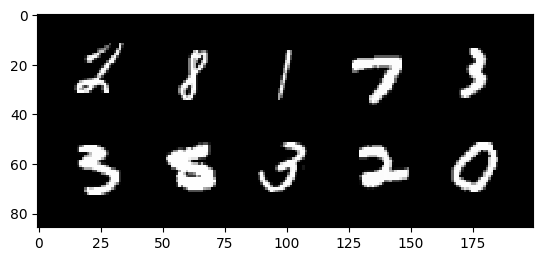

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first 10 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

## Exercise 3
Now, we are ready to define our model. We will start with a simple model, a MultiLayer Perceptron (MLP) with 2 layers.

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        # define the different modules of the network
        super().__init__()
        # How many features should our model have?
        #Size of MNIST images is 28x28 (784)
        self.fc1 = nn.Linear(784, 50)

        # How many outputs should our model have?
        self.fc2 = nn.Linear(50, 10)
        # we also define the non-linearity 
        self.relu = nn.ReLU()



    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ***************************************************
        # INSERT YOUR CODE HERE
        # You should (a) transform the a size that is readable
        # by the MLP and (b) pass the the input x successively 
        # through the layers.
        # ***************************************************
        # transform the image to a vector
        x = x.view(-1, 784)
        # pass the input through the first layer
        x = self.fc1(x)
        # apply the non-linearity
        x = self.relu(x)
        # pass the input through the second layer
        output = self.fc2(x)
        # return the output

        return output

In [19]:
# initialize the model
model = Net()

# move model to device
model = model.to(DEVICE)

# define the optimizer
# Hint: https://pytorch.org/docs/stable/optim.html
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

We now define:
* the `fit` function that performs the training part
* the `predict` function that takes as input the test dataloader and prints the performance metrics (e.g. accuracy)

In [20]:
def train_epoch(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    device: torch.device
    ):
    '''
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    '''

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target)

        # compute the gradients
        loss.backward()


        # perform the gradient step
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    
    return running_loss / len(train_dataloader.dataset)


def fit(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    epochs: int, 
    device: torch.device):
    '''
    the fit method simply calls the train_epoch() method for a 
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model, 
            train_dataloader=train_dataloader, 
            optimizer=optimizer, 
            device=device
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

    return losses

In [21]:
def predict(model: nn.Module, test_dataloader: DataLoader, device: torch.device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100. * correct / len(test_dataloader.dataset)

    print(f'Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)')


We perform a "sanity check". Our model is at the moment initialized randomly and we have 10 classes (each class has approximately the same number of samples). This means that we should get random performance -> ~10% accuracy.

In [22]:
predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0012, Accuracy: 679/10000 (7%)


In [23]:
# train for 10 epochs
losses = fit(
    model=model, 
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

Epoch 0: Loss=0.0022275445143381755
Epoch 1: Loss=0.002123991334438324
Epoch 2: Loss=0.0019918970982233685
Epoch 3: Loss=0.0018311211665471396
Epoch 4: Loss=0.001648569162686666
Epoch 5: Loss=0.001460735370715459
Epoch 6: Loss=0.0012861919303735097
Epoch 7: Loss=0.0011371161679426828
Epoch 8: Loss=0.0010153862824042639
Epoch 9: Loss=0.0009181365003188451
Epoch 10: Loss=0.000841055515408516
Epoch 11: Loss=0.0007788783739010493
Epoch 12: Loss=0.0007280239969491959
Epoch 13: Loss=0.000686246407032013
Epoch 14: Loss=0.0006509857644637426
Epoch 15: Loss=0.0006210167497396469
Epoch 16: Loss=0.0005952786187330882
Epoch 17: Loss=0.0005729184557994207
Epoch 18: Loss=0.0005529892683029175
Epoch 19: Loss=0.000535801729063193


Let's visualize the loss progression.

Text(0.5, 1.0, 'Loss progression across epochs')

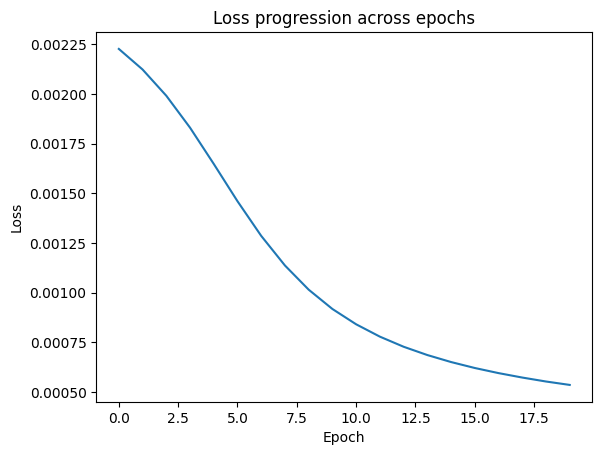

In [24]:
plt.plot(losses)

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss progression across epochs")

In [25]:
predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0003, Accuracy: 8770/10000 (88%)


The results are not very good. There are some major problems. We see from the plot above that the loss keeps dropping and does not "plateau". This indicates that we can run the optimization a few more epochs and improve the performance. Another point is that our learning rate is too slow or the selection of vanilla SGD as our optimizer is not optimal. In the next section we will see that simply changing the optimizer (from SGD to Adam) yields very different results!

## EXercise 4: CNN

Notice that the MLP does not take into account the nature of images: close pixels convey local information that is important. Using an MLP, we do not have the notion of the "pixel neighbourhood". We, therefore, neglect important information with an MLP. There are however models better suited for vision problems, such as Convolutional Neural Networks or CNNs.

With the code structure we have created, we can simply define a CNN and test its performance quickly.

In [26]:
class CNN(nn.Module): 
    def __init__(self):
        super().__init__()
        # ************ YOUR CODE HERE ************
        # define a CNN with 2 convolutional layers, followed by ReLU and Maxpool each, 
        # and a fully connected layer at the end.
        # Hint: you could use nn.Sequential() for the convolutional part
        

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.fc = nn.Linear(320, 10)
            


        
        
        
    def forward(self, x):
            # ************ YOUR CODE HERE ************ 
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [27]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer. Use Adam
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train the CNN
losses = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=15,
    device=DEVICE
)

Epoch 0: Loss=0.00039876683416465916
Epoch 1: Loss=8.737762216478586e-05
Epoch 2: Loss=6.127645360926786e-05
Epoch 3: Loss=5.019429447129369e-05
Epoch 4: Loss=3.9310789899900556e-05
Epoch 5: Loss=3.629385928312937e-05
Epoch 6: Loss=3.139600098753969e-05
Epoch 7: Loss=2.63425107114017e-05
Epoch 8: Loss=2.3513657925650477e-05
Epoch 9: Loss=2.1748005816092094e-05
Epoch 10: Loss=2.048036869770537e-05
Epoch 11: Loss=1.6859580374633273e-05
Epoch 12: Loss=1.58009774905319e-05
Epoch 13: Loss=1.402610222188135e-05
Epoch 14: Loss=1.588905727646003e-05


In [28]:
# How does the CNN perform compared to the MLP?
predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0000, Accuracy: 9900/10000 (99%)


Text(0.5, 1.0, 'Loss progression across epochs')

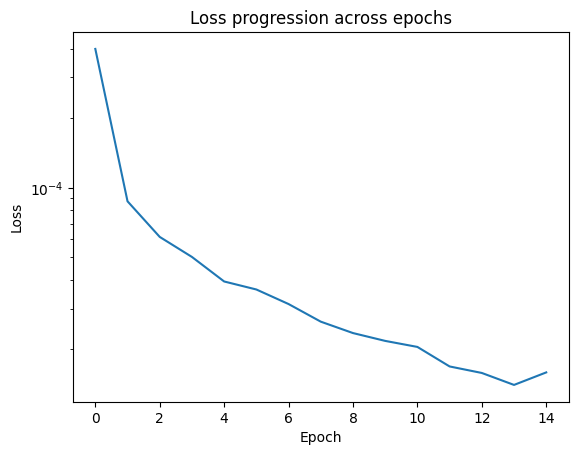

In [29]:
plt.plot(losses)

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Loss progression across epochs")

# Part C: play with CIFAR10 [2 points]

MNIST is a fairly simple dataset. What happens in more challenging datasets? Try to train a network on CIFAR10 dataset and see how it performs. You can use the same code as above, but you need to change the model architecture.

In [30]:
# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 
transform = T.Compose([
    T.ToTensor(),
    # T.Normalize((0.1307,), (0.3081,))
])

# load the train dataset
# Hint: look at 
# 1. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# 2. https://pytorch.org/vision/stable/datasets.html
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
# construct the dataloader for the traininig dataset. 
# Here we shuffle the data to promote stochasticity.
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)


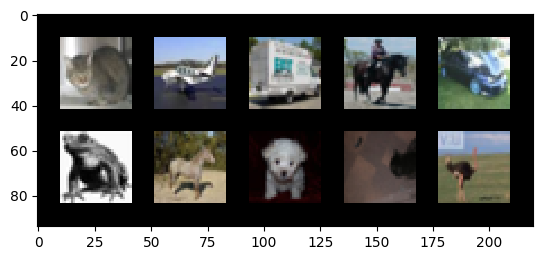

In [32]:
# Get the first 10 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

In [33]:
# Define the model architecture
class CNN_CIFAR(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize the model
cnn_cifar = CNN_CIFAR().to(DEVICE)

# Define the optimizer
optimizer = optim.Adam(cnn_cifar.parameters(), lr=LEARNING_RATE)

# Train the CNN on CIFAR10 dataset
losses = fit(
    model=cnn_cifar, 
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=15,
    device=DEVICE
)


Epoch 0: Loss=0.001924988582134247
Epoch 1: Loss=0.001508970832824707
Epoch 2: Loss=0.0014044374465942383
Epoch 3: Loss=0.0013381150960922242
Epoch 4: Loss=0.0012770716261863708
Epoch 5: Loss=0.00124040372133255
Epoch 6: Loss=0.0012117301082611085
Epoch 7: Loss=0.0011859358596801757
Epoch 8: Loss=0.0011482490944862366
Epoch 9: Loss=0.0011459482765197753
Epoch 10: Loss=0.001108732726573944
Epoch 11: Loss=0.0010992832159996033
Epoch 12: Loss=0.0011034085392951966
Epoch 13: Loss=0.0010767911577224732
Epoch 14: Loss=0.0010654161477088929


In [34]:
# How does the CNN perform compared to the MLP?
predict(model=cnn_cifar, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0006, Accuracy: 5938/10000 (59%)


Text(0.5, 1.0, 'Loss progression across epochs')

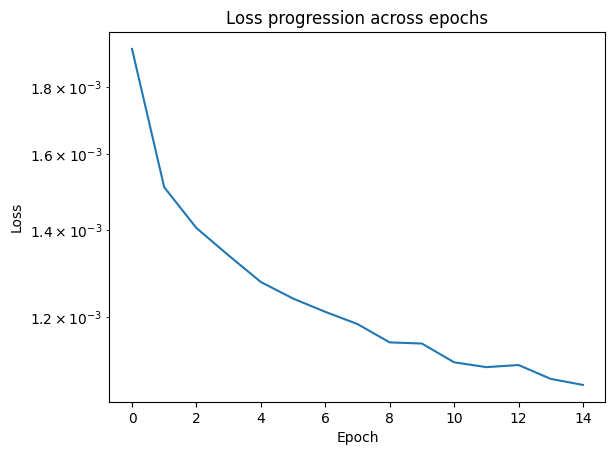

In [35]:
plt.plot(losses)

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Loss progression across epochs")